# 1. Parameters

In [1]:
from pathlib import Path
from os import mkdir
import pandas as pd
import seaborn as sns

cases_root_dir = Path('cases')

figures_path = Path('figures')
if not figures_path.exists():
    mkdir(figures_path)
    
samples_cases = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
cases_paths = [cases_root_dir / f'case-{x}' for x in samples_cases]

metadata_file = Path('input/metadata-subsample-pangolin.tsv')

# 2. Indexing

## 2.1. Samples comparison

In [2]:
from typing import List

index_info_paths = [x / 'index-info.tsv' for x in cases_paths]
index_info_paths = [x for x in index_info_paths if x.exists()]

def read_all_df(index_paths: List[Path]) -> pd.DataFrame:
    dfs = []
    for index in index_paths:
        dfs.append(pd.read_csv(index, sep='\t'))
        
    return pd.concat(dfs).reset_index(drop=True)

index_info_df = read_all_df(index_info_paths)
index_info_df['Samples'] = index_info_df['Name'].str.extract(r'^case-(\d+)').astype(int)
index_info_df.head(5)

,Name,Iteration,Number samples,Number features (all),Number features (no unknown),Number cores,Reference length,Analysis runtime,Analysis memory (max),Analysis memory (max/process),...,Index runtime,Index memory (max),Index memory (max/process),Index size,Tree runtime,Tree memory (max),Tree memory (max/process),Total runtime,Max memory,Samples
0,case-10,1,10,1436,89,32,29903,148.10,1.336492e+09,372428800.0,...,4.66,5.397004e+09,229097472.0,593920.0,104.55,245444608.0,220684288.0,257.31,5.397004e+09,10
1,case-10,2,10,1436,89,32,29903,141.13,1.312379e+09,371302400.0,...,4.24,5.393117e+09,229429248.0,589824.0,96.21,246124544.0,220372992.0,241.58,5.393117e+09,10
2,case-10,3,10,1436,89,32,29903,142.78,1.320149e+09,375214080.0,...,4.22,5.397164e+09,229404672.0,593920.0,90.34,245694464.0,220446720.0,237.34,5.397164e+09,10
3,case-20,1,20,1580,131,32,29903,141.90,1.844453e+09,371617792.0,...,4.52,5.504639e+09,230592512.0,778240.0,108.40,240336896.0,220803072.0,254.82,5.504639e+09,20
4,case-20,2,20,1580,131,32,29903,143.17,1.917329e+09,379027456.0,...,4.73,5.498573e+09,230690816.0,778240.0,123.61,241094656.0,221392896.0,271.51,5.498573e+09,20


### 2.1.2. Runtime plots

In [3]:
index_info_runtime_df = pd.melt(index_info_df, id_vars='Samples',
        value_vars=['Analysis runtime', 'Index runtime', 'Tree runtime'])
index_info_runtime_df = index_info_runtime_df.rename({'variable': 'Stage', 'value': 'Time (seconds)'}, axis='columns')
index_info_runtime_df['Stage'] = index_info_runtime_df['Stage'].str.replace(' runtime', '', regex=False)
index_info_runtime_df.head(6)

,Samples,Stage,Time (seconds)
0,10,Analysis,148.10
1,10,Analysis,141.13
2,10,Analysis,142.78
3,20,Analysis,141.90
4,20,Analysis,143.17
5,20,Analysis,141.15


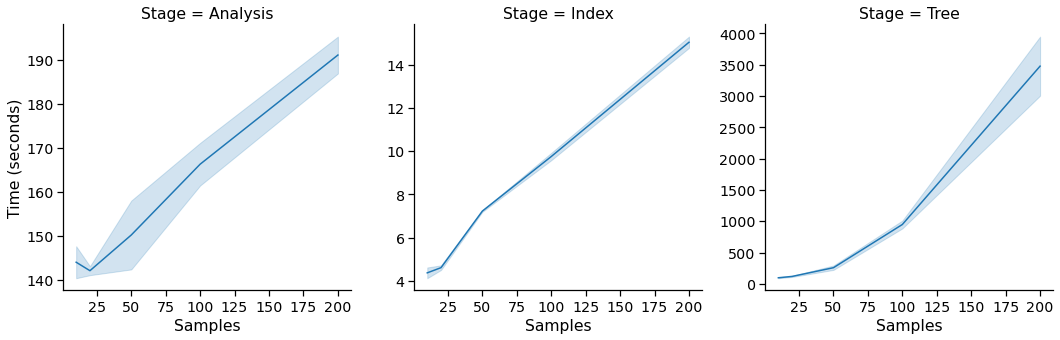

In [4]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Time (seconds)', col="Stage", ci="sd", kind="line",
                    data=index_info_runtime_df, markers=True,
                   facet_kws={'sharey': False, 'sharex': True}, col_wrap=3, height=5)

### 2.1.3. Analysis memory plots

In [5]:
index_info_memory_df = pd.melt(index_info_df, id_vars='Samples',
        value_vars=['Analysis memory (max)', 'Index memory (max)', 'Tree memory (max)'])
index_info_memory_df['value'] = index_info_memory_df['value'].apply(lambda x: x/(1024**3))
index_info_memory_df = index_info_memory_df.rename({'variable': 'Stage', 'value': 'Memory (GB)'}, axis='columns')
index_info_memory_df['Stage'] = index_info_memory_df['Stage'].str.replace(' memory (max)', '', regex=False)
index_info_memory_df.head(3)

,Samples,Stage,Memory (GB)
0,10,Analysis,1.244705
1,10,Analysis,1.222248
2,10,Analysis,1.229485


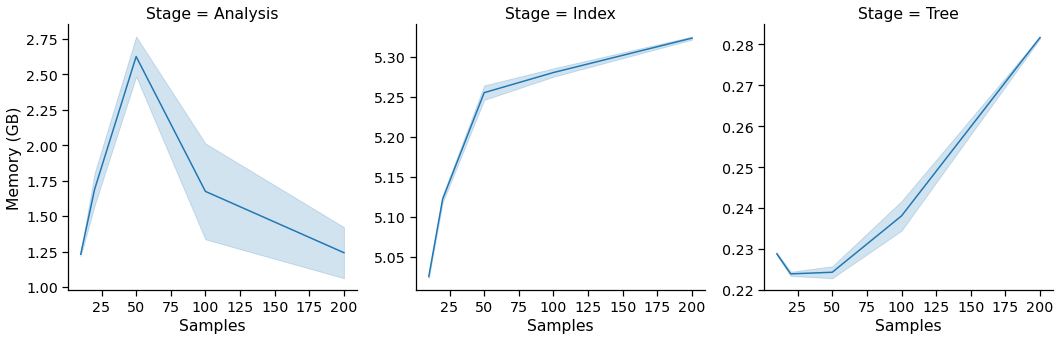

In [6]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Memory (GB)', col="Stage", ci="sd", kind="line", data=index_info_memory_df,
                   facet_kws={'sharey': False, 'sharex': True}, col_wrap=3, height=5)

### 2.1.3. Disk usage plots

In [7]:
index_info_disk_df = pd.melt(index_info_df, id_vars='Samples',
        value_vars=['Analysis disk uage', 'Index size'])
index_info_disk_df['value'] = index_info_disk_df['value'].apply(lambda x: x/(1024**3))
index_info_disk_df = index_info_disk_df.rename({'variable': 'Stage', 'value': 'Disk (GB)'}, axis='columns')
index_info_disk_df['Stage'] = index_info_disk_df['Stage'].str.replace(' disk uage', '', regex=False)
index_info_disk_df['Stage'] = index_info_disk_df['Stage'].str.replace(' size', '', regex=False)
index_info_disk_df.head(3)

,Samples,Stage,Disk (GB)
0,10,Analysis,3.214535
1,10,Analysis,3.214523
2,10,Analysis,3.214535


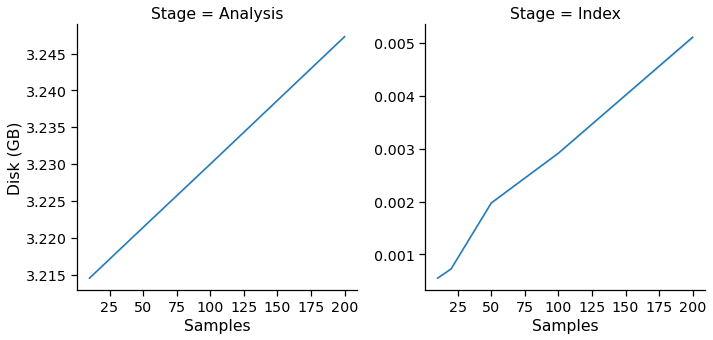

In [8]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Disk (GB)', col="Stage", ci="sd", kind="line", data=index_info_disk_df,
                   facet_kws={'sharey': False, 'sharex': True}, col_wrap=3, height=5)

# 3. Querying

## 3.1. Querying API

In [9]:
query_paths = [x / 'query-api.tsv' for x in cases_paths]
query_paths = [x for x in query_paths if x.exists()]

query_df = read_all_df(query_paths)
query_df['Samples'] = query_df['Name'].str.extract(r'^case-(\d+)').astype(int)
query_df['Time'] = query_df['Time'].apply(lambda x: x * 1000)
query_df['Number of features (thousands)'] = query_df['Number features (all)'] / 1000
query_df = query_df.rename({'Time': 'Time (ms)'}, axis='columns')
query_df.head(5)

,Name,Kind,Number samples,Number features (no unknown),Number features (all),Number executions,Iteration,Time (ms),Samples,Number of features (thousands)
0,case-10,db.samples_query,10,89,1436,500,1,0.942868,10,1.436
1,case-10,db.samples_query,10,89,1436,500,2,0.975226,10,1.436
2,case-10,db.samples_query,10,89,1436,500,3,0.939787,10,1.436
3,case-10,db.samples_query,10,89,1436,500,4,0.953568,10,1.436
4,case-10,db.samples_query,10,89,1436,500,5,0.951405,10,1.436


### 3.1.1. Compare runtime for single set of samples

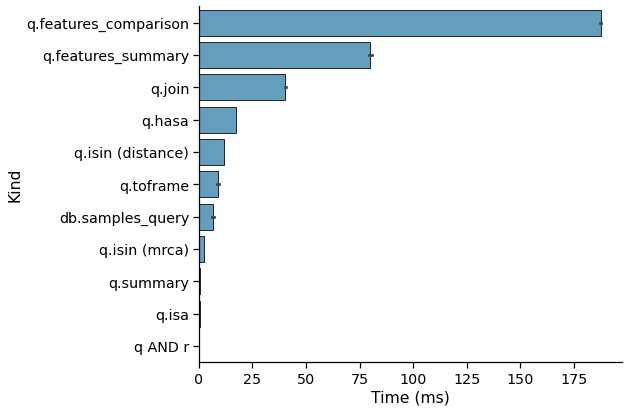

In [10]:
query_samples = query_df[query_df['Samples'] == 200]
query_samples = query_samples.sort_values('Time (ms)', ascending=False)
query_samples

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(
        data=query_samples, kind="bar",
        y="Kind", x="Time (ms)", hue=None,
        ci="sd", height=6, aspect=1.5, alpha=0.8, color="#2b8cbe", edgecolor="black"
    )

### 3.1.2. Compare runtime vs. all samples

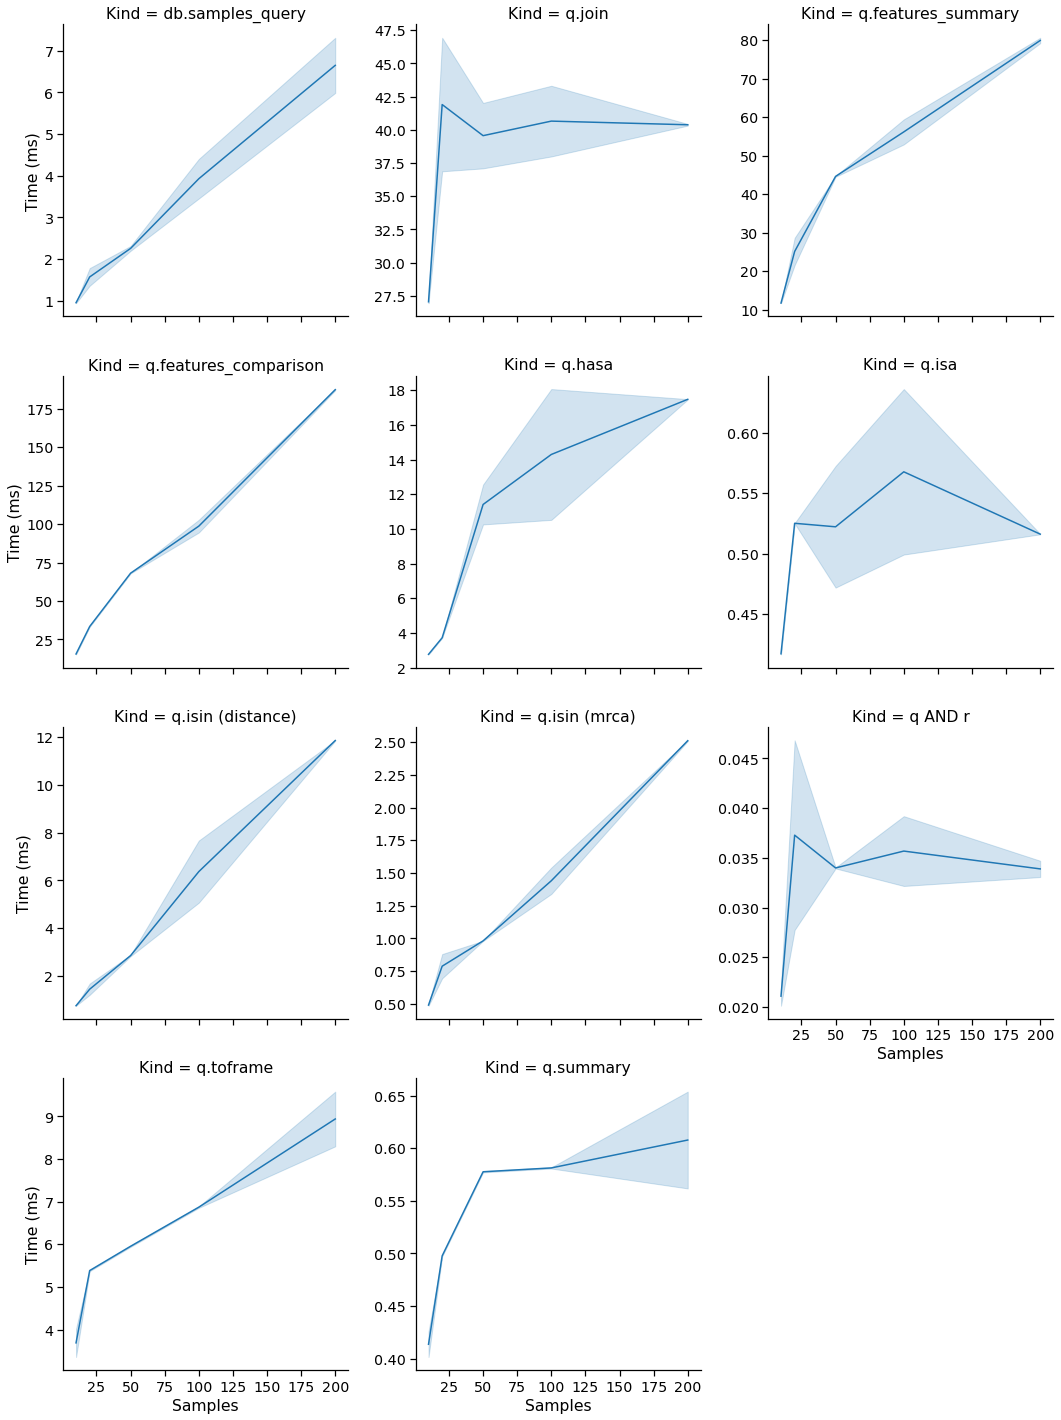

In [11]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Time (ms)', col="Kind", ci="sd", kind="line", data=query_df,
                   facet_kws={'sharey': False, 'sharex': True}, col_wrap=3, height=5)

### 3.1.3. Compare runtime vs. number of features

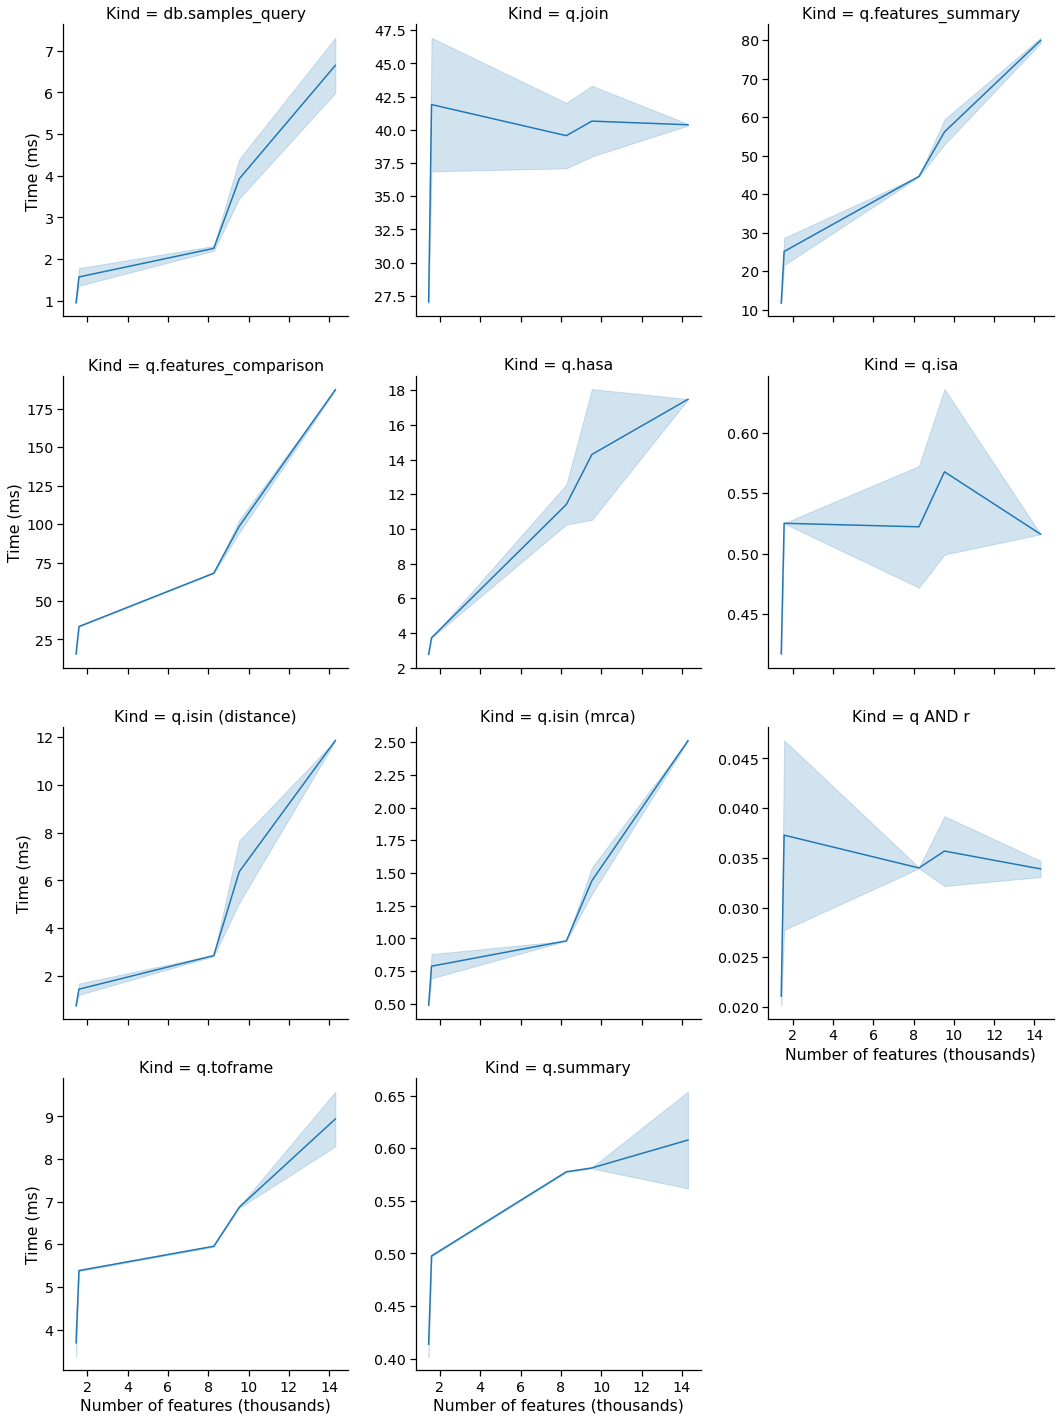

In [12]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Number of features (thousands)', y='Time (ms)', col="Kind", ci="sd", kind="line", data=query_df,
                       facet_kws={'sharey': False, 'sharex': True}, col_wrap=3, height=5)

## 3.2. Querying CLI

In [13]:
query_paths_cli = [x / 'query-cli.tsv' for x in cases_paths]
query_paths_cli = [x for x in query_paths_cli if x.exists()]
query_cli_df = read_all_df(query_paths_cli)
query_cli_df['Samples'] = query_cli_df['Name'].str.extract(r'^case-(\d+)').astype(int)
query_cli_df['Time (ms)'] = query_cli_df['Runtime'].apply(lambda x: x * 1000)
query_cli_df['Memory (MB)'] = query_cli_df['Memory (max)'].apply(lambda x: x / (1024**2))
query_cli_df['Number of features (thousands)'] = query_cli_df['Number features (all)'] / 1000
query_cli_df.head(5)

,Name,Kind,Iteration,Number samples,Number features (no unknown),Number features (all),Runtime,Memory (max),Mmemory (max/process),Samples,Time (ms),Memory (MB),Number of features (thousands)
0,case-10,query hasa,1,10,89,1436,4.48,237846528.0,220233728.0,10,4480.0,226.828125,1.436
1,case-10,query hasa,2,10,89,1436,4.34,237793280.0,220676096.0,10,4340.0,226.777344,1.436
2,case-10,query hasa,3,10,89,1436,4.48,238538752.0,220864512.0,10,4480.0,227.488281,1.436
3,case-10,query hasa,4,10,89,1436,4.61,238432256.0,220950528.0,10,4610.0,227.386719,1.436
4,case-10,query hasa,5,10,89,1436,4.34,238215168.0,220917760.0,10,4340.0,227.179688,1.436


### 3.2.1. Compare runtime for single set of samples

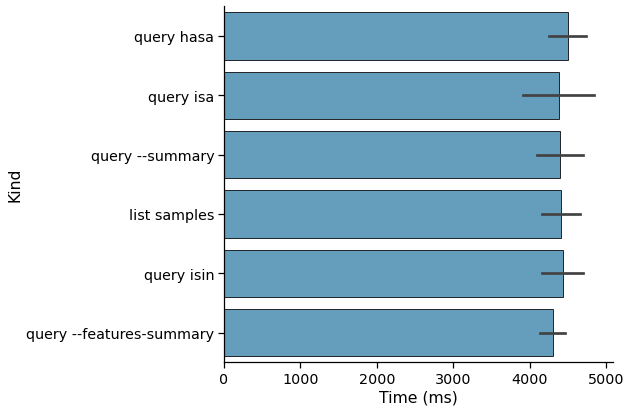

In [14]:
query_cli_samples = query_cli_df[query_cli_df['Samples'] == 200]
query_cli_samples = query_cli_samples.sort_values('Time (ms)', ascending=False)

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(data=query_cli_samples, kind="bar",
                  y="Kind", x="Time (ms)", hue=None,
                  ci="sd", height=6, aspect=1.5, alpha=0.8,
                  color="#2b8cbe", edgecolor="black")

#### 3.2.1.1. Compare runtime between CLI and API

In [15]:
qcli = query_cli_samples.loc[:, ['Name', 'Kind', 'Number samples', 'Time (ms)']]
qcli['Kind'] = qcli['Kind'].replace({
        'query isa': 'isa',
        'query hasa': 'hasa',
        'query isin': 'isin',
        'query --features-summary': 'features summary',
    })
qcli['Method'] = 'CLI'
qapi = query_samples.loc[:, ['Name', 'Kind', 'Number samples', 'Time (ms)']]
qapi['Kind'] = qapi['Kind'].replace({
        'q.isa': 'isa',
        'q.hasa': 'hasa',
        'q.isin': 'isin',
        'q.features_summary': 'features summary',
    })
qapi['Method'] = 'API'

q_cli_api = pd.concat([qcli, qapi])
q_cli_api = q_cli_api[q_cli_api['Kind'].isin(['isa', 'hasa', 'isin', 'features summary'])]
q_cli_api = q_cli_api.sort_values(['Time (ms)'])
q_cli_api

,Name,Kind,Number samples,Time (ms),Method
499,case-200,isa,200,0.515884,API
495,case-200,isa,200,0.516051,API
496,case-200,isa,200,0.516070,API
491,case-200,isa,200,0.516090,API
498,case-200,isa,200,0.516099,API
...,...,...,...,...,...
243,case-200,hasa,200,4740.000000,CLI
263,case-200,isin,200,4770.000000,CLI
250,case-200,isa,200,4790.000000,CLI
251,case-200,isa,200,5040.000000,CLI


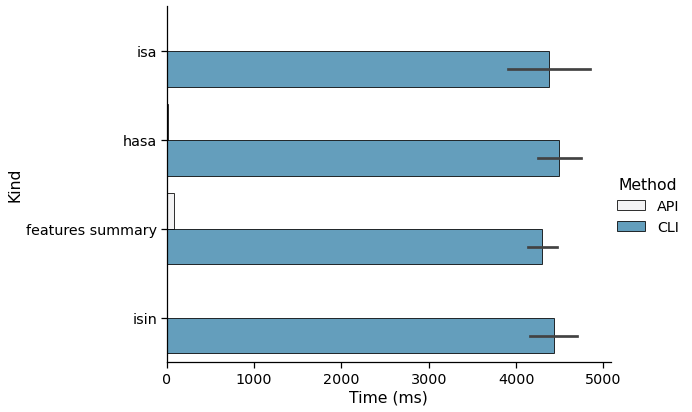

In [16]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(data=q_cli_api, kind="bar",
                  y="Kind", x="Time (ms)", hue='Method',
                  ci="sd", height=6, aspect=1.5, alpha=0.8,
                  color="#2b8cbe", edgecolor="black")

### 3.2.2. Compare runtime to number of samples

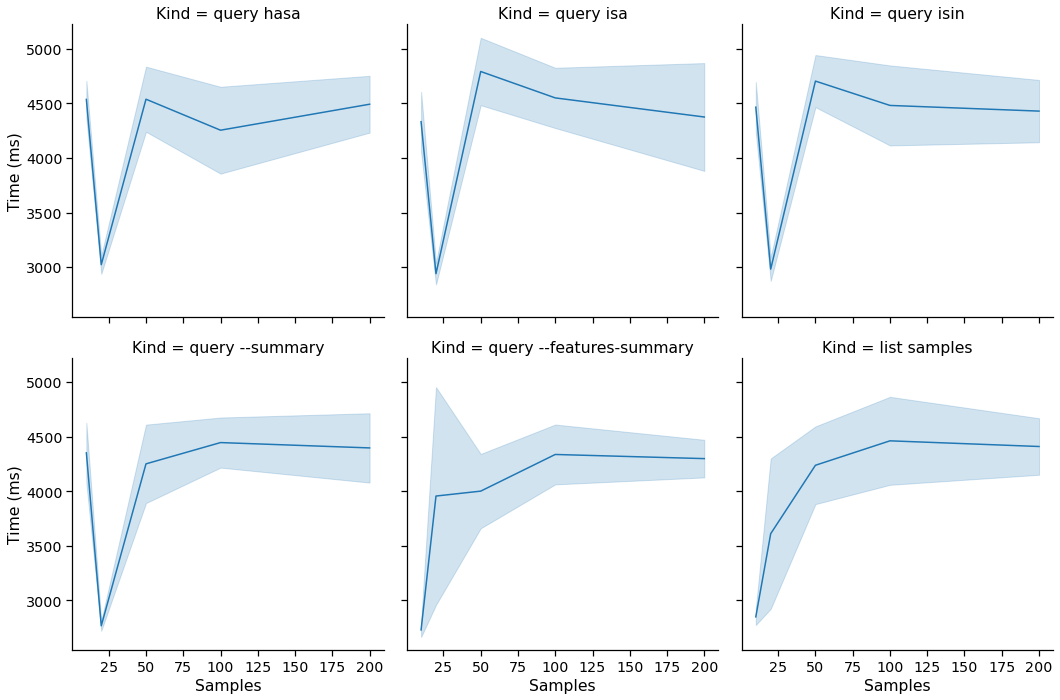

In [17]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Time (ms)', col="Kind", ci="sd", kind="line", data=query_cli_df,
                    facet_kws={'sharey': True, 'sharex': True}, col_wrap=3, height=5)

### 3.2.3. Compare peak memory to number of samples

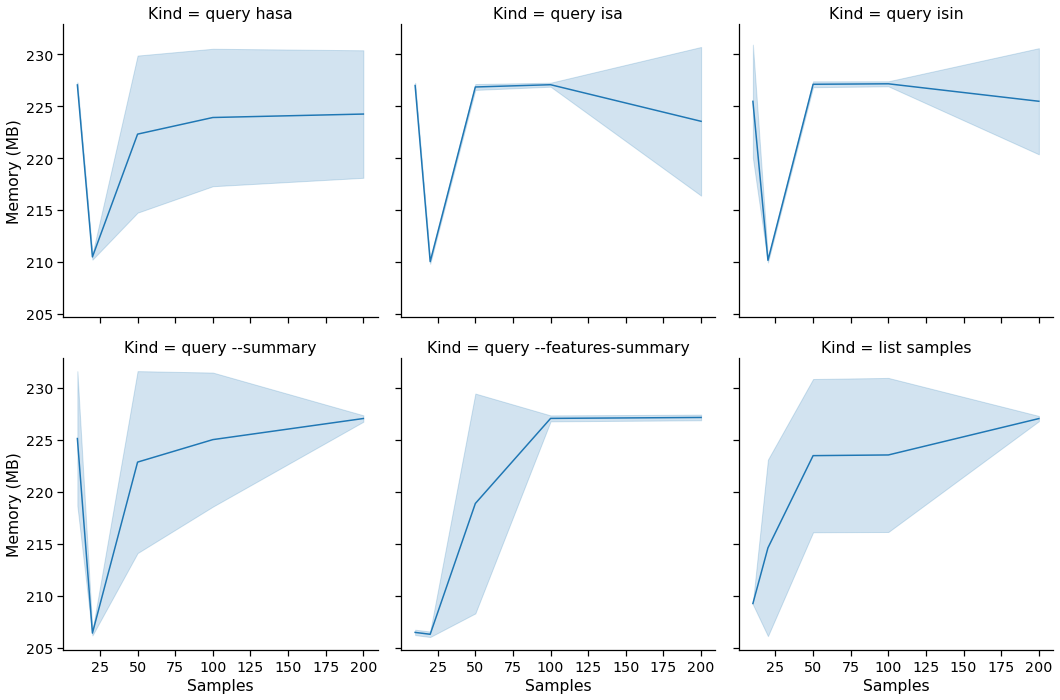

In [18]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Memory (MB)', col="Kind", ci="sd", kind="line", data=query_cli_df,
                    facet_kws={'sharey': True, 'sharex': True}, col_wrap=3, height=5)

### 3.2.4. Compare runtime to number of features

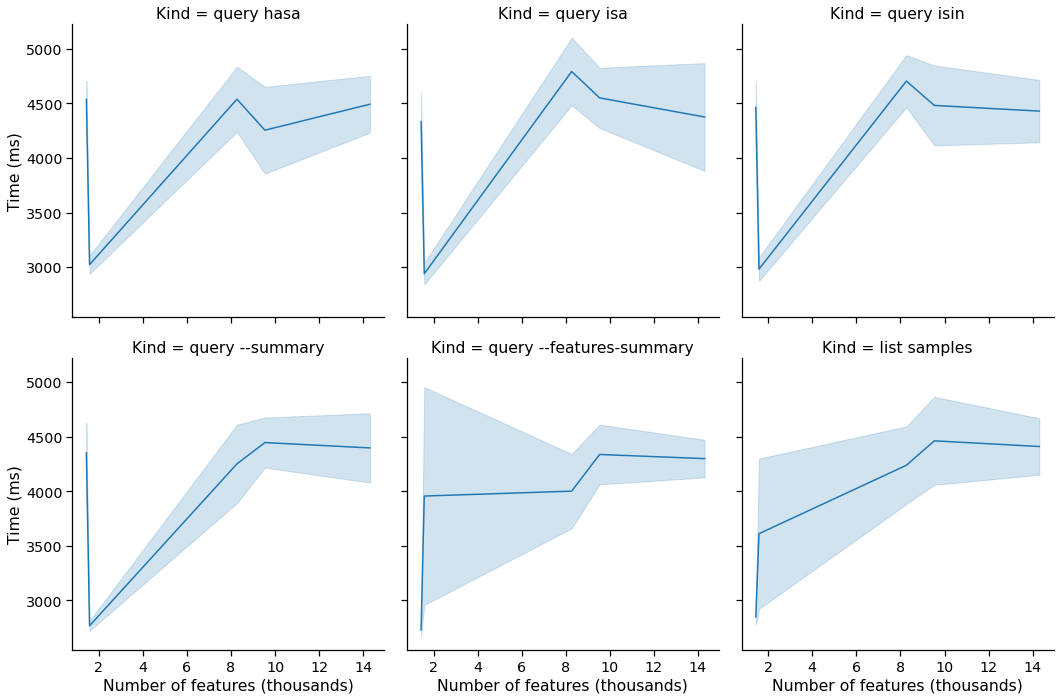

In [19]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Number of features (thousands)', y='Time (ms)', col="Kind", ci="sd", kind="line",
                    data=query_cli_df,
                   facet_kws={'sharey': True, 'sharex': True}, col_wrap=3, height=5)

### 3.2.5. Compare peak memory to number of features

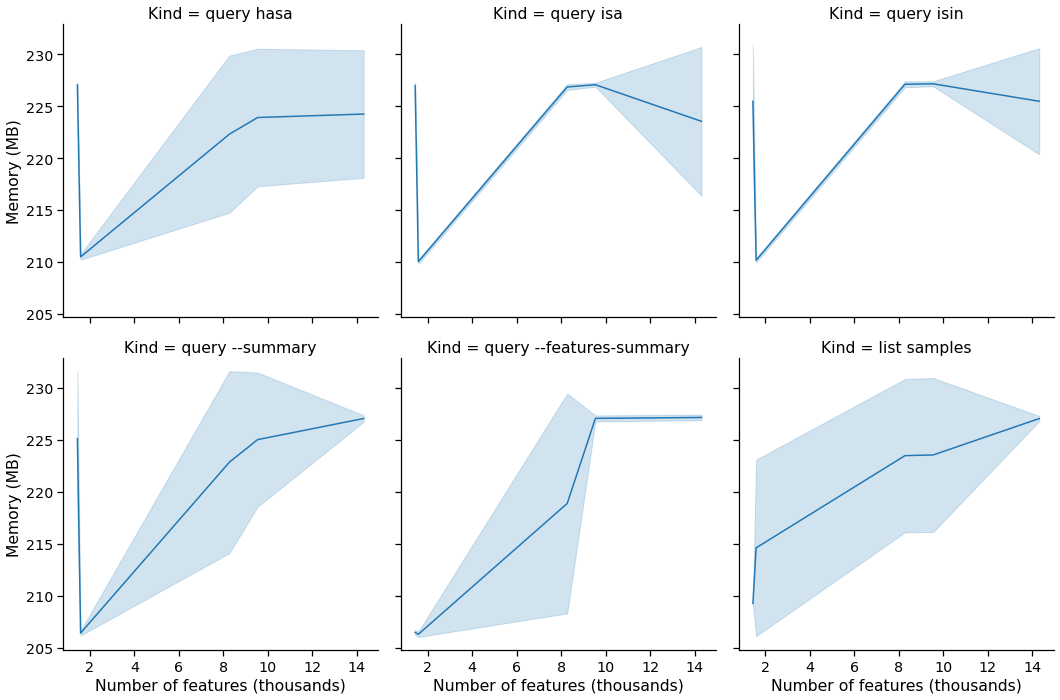

In [20]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Number of features (thousands)', y='Memory (MB)', col="Kind", ci="sd", kind="line",
                    data=query_cli_df,
                   facet_kws={'sharey': True, 'sharex': True}, col_wrap=3, height=5)

# 4. Tree vs. clustering

## 4.1. Connect to index and metadata file

In [21]:
import genomics_data_index.api as gdi

number_samples = 200
min_samples_cluster = 2

clustering_index = cases_root_dir / f'case-{number_samples}' / 'index'
db = gdi.GenomicsDataIndex.connect(clustering_index)
db

<GenomicsDataIndex(samples=200)>

In [22]:
import pandas as pd

metadata_df = pd.read_csv(metadata_file, sep='\t')
metadata_df.head(2)

,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,ambiguity_score,scorpio_call,scorpio_support,scorpio_conflict,version,pangolin_version,pangoLEARN_version,pango_version,status,note
0,England/QEUH-148725F/2021,ncov,EPI_ISL_1487327,OU224813,ERR5679447,2021-03-28,Europe,United Kingdom,England,NaN,...,1.0,Alpha (B.1.1.7-like),0.9565,0.0435,PLEARN-v1.2.66,3.1.11,2021-08-24,v1.2.66,passed_qc,scorpio call: Alt alleles 22; Ref alleles 1; A...
1,England/MILK-1535AC0/2021,ncov,EPI_ISL_1985652,OU266415,ERR5905912,2021-04-24,Europe,United Kingdom,England,NaN,...,1.0,B.1.1.318-like,0.8421,0.0000,PLEARN-v1.2.66,3.1.11,2021-08-24,v1.2.66,passed_qc,scorpio call: Alt alleles 16; Ref alleles 0; A...


In [23]:
metadata_df.columns

Index(['strain', 'virus', 'gisaid_epi_isl', 'genbank_accession',
       'sra_accession', 'date', 'region', 'country', 'division', 'location',
       'region_exposure', 'country_exposure', 'division_exposure', 'segment',
       'length', 'host', 'age', 'sex', 'Nextstrain_clade', 'pango_lineage',
       'GISAID_clade', 'originating_lab', 'submitting_lab', 'authors', 'url',
       'title', 'paper_url', 'date_submitted', 'sampling_strategy',
       'missing_data', 'divergence', 'nonACGTN', 'rare_mutations',
       'snp_clusters', 'QC_missing_data', 'QC_mixed_sites',
       'QC_rare_mutations', 'QC_snp_clusters', 'clock_deviation',
       'missing_data_percent', 'taxon', 'lineage', 'conflict',
       'ambiguity_score', 'scorpio_call', 'scorpio_support',
       'scorpio_conflict', 'version', 'pangolin_version', 'pangoLEARN_version',
       'pango_version', 'status', 'note'],
      dtype='object')

In [24]:
metadata_df['lineage'].value_counts()

B.1.1.7       4350
AY.4          1186
B.1.617.2      537
B.1.2          381
B.1.177        295
              ... 
B.1.162          1
B.1.1.453        1
B.1.177.6        1
B.1.527          1
B.1.160.11       1
Name: lineage, Length: 434, dtype: int64

## 4.2. Initiate query

In [25]:
q = db.samples_query(reference_name='NC_045512', universe='mutations').set_outgroup('NC_045512')\
      .join(metadata_df, sample_names_column='strain')
q

<MutationTreeSamplesQuery[selected=100% (200/200) samples, unknown=0% (0/200) samples]>

## 4.3. Look at what lineages are available

In [26]:
q.toframe()['lineage'].value_counts()

B.1           77
B.1.1         18
A.1           16
B             11
B.1.1.7        9
B.1.1.39       3
AY.4           3
B.1.177.23     3
B.40           3
B.1.223        2
B.39           2
B.1.391        2
B.1.22         2
B.1.93         2
B.1.23         2
A              2
B.1.177        2
B.1.617.2      2
B.1.595        1
B.1.535        1
B.1.367        1
B.31           1
B.1.360        1
B.1.39         1
B.1.389        1
A.2.2          1
B.45           1
B.6            1
D.2            1
B.4            1
B.27           1
B.55           1
B.1.177.86     1
B.1.428        1
B.1.1.323      1
B.1.494        1
B.1.1.1        1
AY.6           1
B.1.384        1
B.1.1.70       1
AY.12          1
B.1.1.231      1
B.4.5          1
B.1.234        1
B.1.13         1
B.60           1
A.3            1
B.23           1
A.2            1
C.35           1
B.1.8          1
B.1.222        1
B.1.320        1
B.1.371        1
B.1.1.220      1
B.1.416.1      1
B.1.545        1
Name: lineage, dtype: int64

## 4.4. Cluster scoring (ML tree)

In [27]:
from genomics_data_index.api.query.impl.ClusterScorer import ClusterScorer

scorer = ClusterScorer(q)
scorer

In [28]:
scores_ml = scorer.score_groupby(groupby_column='lineage', min_samples_count=min_samples_cluster)
scores_ml['Score (ML)'] = scores_ml['Score']
scores_ml

,Score,Sample Count,Score (ML)
lineage,,,
A,0.666667,2,0.666667
A.1,1.000000,16,1.000000
AY.4,0.750000,3,0.750000
B,0.055000,11,0.055000
B.1,0.652542,77,0.652542
B.1.1,0.473684,18,0.473684
B.1.1.39,1.000000,3,1.000000
B.1.1.7,1.000000,9,1.000000
B.1.177,0.333333,2,0.333333


## 4.5. Cluster scoring (kmer trees)

### 4.5.1. Build and score 31-mer tree

In [29]:
from ete3 import Tree, ClusterTree

# Used due to a bug in the software which uses the original filenames as names in the tree instead
# of the sample names. This can be removed when the bug is fixed.
def fix_kmer_tree_names(tree: Tree) -> Tree:
    newick_str = tree.write()
    newick_fixed = newick_str.replace('_','/')
    newick_fixed = newick_fixed.replace('NA/','NA_')
    newick_fixed = newick_fixed.replace('/MA/','/MA_')
    newick_fixed = newick_fixed.replace('/UNC/','/UNC_')
    newick_fixed = newick_fixed.replace('_MGH/','_MGH_')
    newick_fixed = newick_fixed.replace('/PL/','/PL_')
    newick_fixed = newick_fixed.replace('Northern/Ireland/','Northern_Ireland/')
    newick_fixed = newick_fixed.replace('/MA/','/MA_')
    
    # Undo replacements that shouldn't have been made
    newick_fixed = newick_fixed.replace('USA/NYP-WCM-COVSUBJ/0668/1/P/2020' ,'USA/NYP-WCM-COVSUBJ_0668_1_P/2020')
            
    return ClusterTree(newick_fixed)

In [30]:
q31 = db.samples_query().build_tree(kind='kmer', kmer_size=31)\
        .join(metadata_df, sample_names_column='strain')
q31._tree = fix_kmer_tree_names(q31.tree)
q31

<KmerTreeSamplesQuery[selected=100% (200/200) samples, unknown=0% (0/200) samples]>

In [31]:
score_kmer_31 = ClusterScorer(q31).score_groupby(groupby_column='lineage',
                                                 min_samples_count=min_samples_cluster)
score_kmer_31['Score (kmer=31)'] = score_kmer_31['Score']
score_kmer_31

,Score,Sample Count,Score (kmer=31)
lineage,,,
A,0.014815,2,0.014815
A.1,0.080808,16,0.080808
AY.4,0.428571,3,0.428571
B,0.057292,11,0.057292
B.1,0.403141,77,0.403141
B.1.1,0.091837,18,0.091837
B.1.1.39,0.016043,3,0.016043
B.1.1.7,0.048913,9,0.048913
B.1.177,0.010152,2,0.010152


### 4.5.2. Build and score 51-mer tree

In [32]:
q51 = db.samples_query().build_tree(kind='kmer', kmer_size=51)\
        .join(metadata_df, sample_names_column='strain')
q51._tree = fix_kmer_tree_names(q51.tree)
q51

<KmerTreeSamplesQuery[selected=100% (200/200) samples, unknown=0% (0/200) samples]>

In [33]:
score_kmer_51 = ClusterScorer(q51).score_groupby(groupby_column='lineage',
                                                 min_samples_count=min_samples_cluster)
score_kmer_51['Score (kmer=51)'] = score_kmer_51['Score']
score_kmer_51

,Score,Sample Count,Score (kmer=51)
lineage,,,
A,0.666667,2,0.666667
A.1,0.080808,16,0.080808
AY.4,0.428571,3,0.428571
B,0.070513,11,0.070513
B.1,0.416216,77,0.416216
B.1.1,0.107143,18,0.107143
B.1.1.39,0.015306,3,0.015306
B.1.1.7,0.050847,9,0.050847
B.1.177,0.010363,2,0.010363


### 4.5.2. Build and score 71-mer tree

In [34]:
q71 = db.samples_query().build_tree(kind='kmer', kmer_size=71)\
        .join(metadata_df, sample_names_column='strain')
q71._tree = fix_kmer_tree_names(q71.tree)
q71

<KmerTreeSamplesQuery[selected=100% (200/200) samples, unknown=0% (0/200) samples]>

In [35]:
score_kmer_71 = ClusterScorer(q71).score_groupby(groupby_column='lineage',
                                                 min_samples_count=min_samples_cluster)
score_kmer_71['Score (kmer=71)'] = score_kmer_71['Score']
score_kmer_71

,Score,Sample Count,Score (kmer=71)
lineage,,,
A,0.013072,2,0.013072
A.1,0.080808,16,0.080808
AY.4,0.016575,3,0.016575
B,0.056701,11,0.056701
B.1,0.437500,77,0.437500
B.1.1,0.091837,18,0.091837
B.1.1.39,0.015544,3,0.015544
B.1.1.7,0.046154,9,0.046154
B.1.177,0.012658,2,0.012658


## 4.6. Plot cluster scores

In [36]:
scores_df = scores_ml.copy().drop(['Score'], axis='columns')
for other_df in [score_kmer_31, score_kmer_51, score_kmer_71]:
    other_df = other_df.drop(['Score', 'Sample Count'], axis='columns')
    scores_df = scores_df.merge(other_df, left_index=True, right_index=True)
scores_df = scores_df.reset_index()
scores_df

,lineage,Sample Count,Score (ML),Score (kmer=31),Score (kmer=51),Score (kmer=71)
0,A,2,0.666667,0.014815,0.666667,0.013072
1,A.1,16,1.000000,0.080808,0.080808,0.080808
2,AY.4,3,0.750000,0.428571,0.428571,0.016575
3,B,11,0.055000,0.057292,0.070513,0.056701
4,B.1,77,0.652542,0.403141,0.416216,0.437500
5,B.1.1,18,0.473684,0.091837,0.107143,0.091837
6,B.1.1.39,3,1.000000,0.016043,0.015306,0.015544
7,B.1.1.7,9,1.000000,0.048913,0.050847,0.046154
8,B.1.177,2,0.333333,0.010152,0.010363,0.012658
9,B.1.177.23,3,1.000000,0.017341,0.051724,0.024390


In [37]:
scores_long_df = pd.melt(scores_df, id_vars='lineage',
                         value_vars=['Score (ML)', 'Score (kmer=31)', 'Score (kmer=51)', 'Score (kmer=71)'])
scores_long_df = scores_long_df.rename({'lineage': 'Lineage', 'variable': 'Method', 'value': 'Score'}, axis='columns')
scores_long_df.head(3)

,Lineage,Method,Score
0,A,Score (ML),0.666667
1,A.1,Score (ML),1.000000
2,AY.4,Score (ML),0.750000


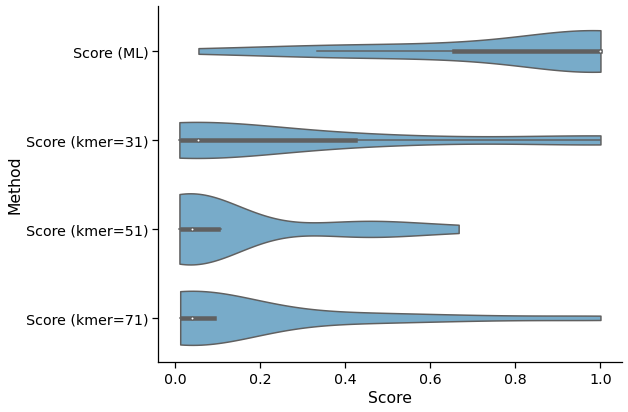

In [48]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(data=scores_long_df, kind="violin",
                    y="Method", x="Score", hue=None,
                    scale='area', inner='box',
                    ci=None, height=6, aspect=1.5,
                    cut=0,
                    color="#6baed6", edgecolor="black")

## 4.7 Visualize clusters

In [52]:
top_lineages_ml = scores_df.sort_values('Score (ML)', ascending=False).head(5)
top_lineages_ml

,lineage,Sample Count,Score (ML),Score (kmer=31),Score (kmer=51),Score (kmer=71)
9,B.1.177.23,3,1.0,0.017341,0.051724,0.024390
1,A.1,16,1.0,0.080808,0.080808,0.080808
16,B.39,2,1.0,1.000000,0.020619,0.090909
15,B.1.93,2,1.0,1.000000,0.027027,0.016667
13,B.1.391,2,1.0,0.012579,0.013245,0.016129


### 4.7.1. Visualize top ML scores

#### 4.7.1.1. On ML tree

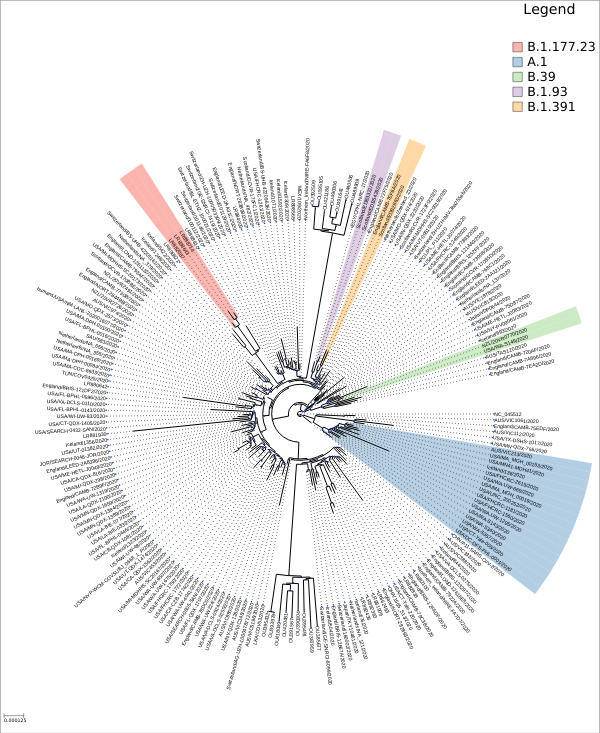

In [53]:
ts = q.tree_styler(mode='c', annotate_box_width=24, legend_nsize=24, legend_fsize=24,
                   annotate_opacity_absent=1.0,
                   legend_type_label_present='', legend_type_label_unknown='',
                   legend_title='Legend', annotate_show_box_label=False,
                   include_unknown=False, annotate_color_unknown='black',
                   tree_scale=400000,
                  )
for lineage in top_lineages_ml['lineage'].tolist():
    ts = ts.highlight(q.isa(lineage, isa_column='lineage', kind='dataframe'), legend_label=lineage)
ts.render(w=600)

#### 4.7.1.2. On kmer=31 tree

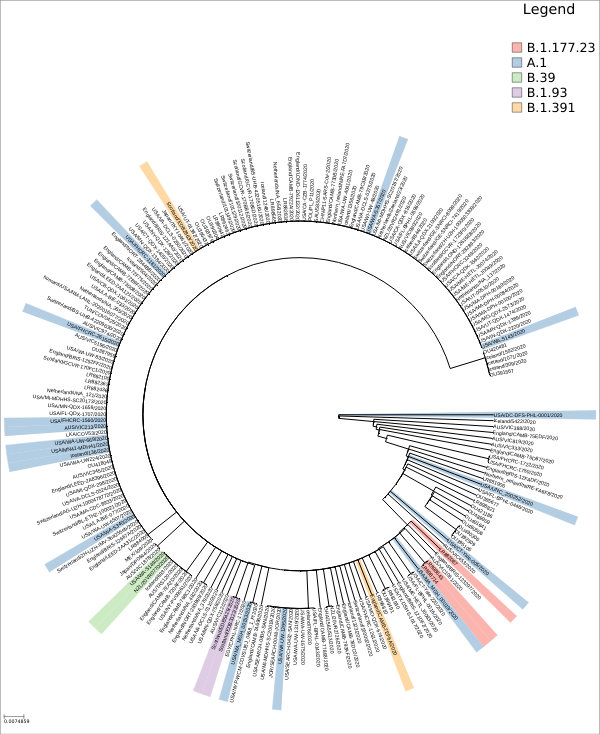

In [54]:
ts31 = q31.tree_styler(mode='c', annotate_box_width=24, legend_nsize=24, legend_fsize=24,
                   annotate_opacity_absent=1.0,
                   legend_type_label_present='', legend_type_label_unknown='',
                   legend_title='Legend', annotate_show_box_label=False,
                   include_unknown=False, annotate_color_unknown='black')
for lineage in top_lineages_ml['lineage'].tolist():
    ts31 = ts31.highlight(q.isa(lineage, isa_column='lineage', kind='dataframe'), legend_label=lineage)
ts31.render(w=600)

### 4.7.2. Visualize top kmer=31 scores

#### 4.7.2.1. On kmer=31 tree

In [55]:
top_lineages_k31 = scores_df.sort_values('Score (kmer=31)', ascending=False).head(5)
top_lineages_k31

,lineage,Sample Count,Score (ML),Score (kmer=31),Score (kmer=51),Score (kmer=71)
16,B.39,2,1.000000,1.000000,0.020619,0.090909
15,B.1.93,2,1.000000,1.000000,0.027027,0.016667
11,B.1.223,2,1.000000,1.000000,0.019802,0.012121
14,B.1.617.2,2,0.333333,0.500000,0.500000,0.666667
2,AY.4,3,0.750000,0.428571,0.428571,0.016575


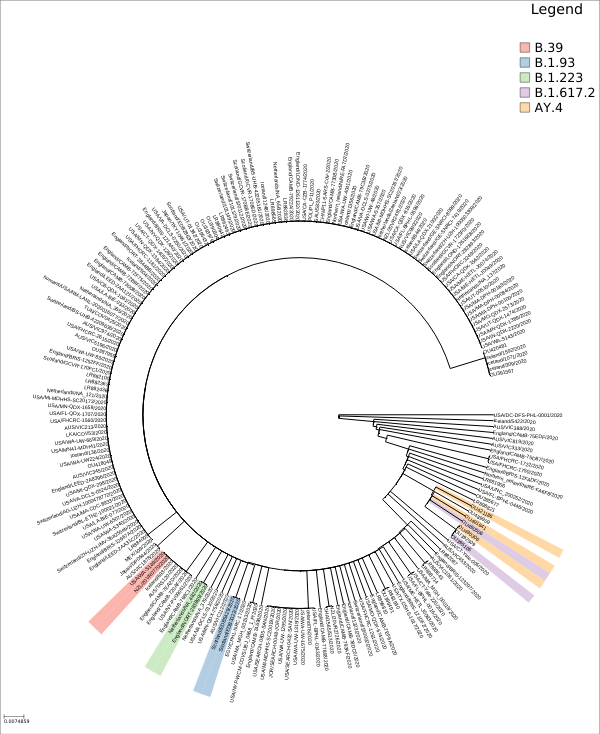

In [57]:
tstk_31 = q31.tree_styler(mode='c', annotate_box_width=24, legend_nsize=24, legend_fsize=24,
                   annotate_opacity_absent=1.0,
                   legend_type_label_present='', legend_type_label_unknown='',
                   legend_title='Legend', annotate_show_box_label=False,
                   include_unknown=False, annotate_color_unknown='black')
for lineage in top_lineages_k31['lineage'].tolist():
    tstk_31 = tstk_31.highlight(q.isa(lineage, isa_column='lineage', kind='dataframe'), legend_label=lineage)
tstk_31.render(w=600)

#### 4.7.2.2. On ML tree

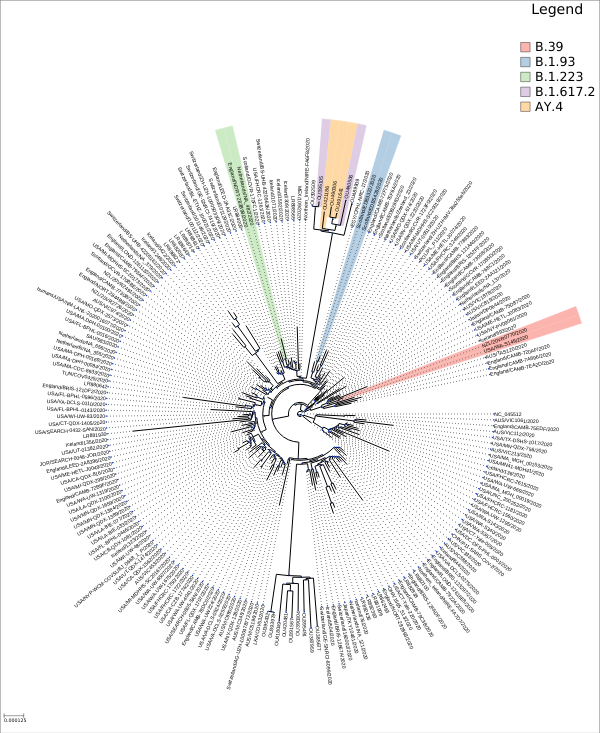

In [58]:
tstk = q.tree_styler(mode='c', annotate_box_width=24, legend_nsize=24, legend_fsize=24,
                   annotate_opacity_absent=1.0,
                   legend_type_label_present='', legend_type_label_unknown='',
                   legend_title='Legend', annotate_show_box_label=False,
                   include_unknown=False, annotate_color_unknown='black',
                   tree_scale=400000,
                  )
for lineage in top_lineages_k31['lineage'].tolist():
    tstk = tstk.highlight(q.isa(lineage, isa_column='lineage', kind='dataframe'), legend_label=lineage)
tstk.render(w=600)